# SQL Query

Base Table:

```
SELECT * FROM
TRX_FAILURE
```

Detailed Queries:



```
CREATE TABLE XXMO_WO_TRX_WITH_PRED AS
SELECT * FROM
XXMO_WORK_ORDER_TRX LEFT JOIN XXMO_PREDICTION_TBL
USING (ORGANIZATION_CODE, ITEM);
```


```
CREATE TABLE M AS SELECT A.ITEM || '_' || A.ORGANIZATION_CODE AS unique_id, A.* FROM  XXMO_WO_TRX_MONTH_TBL A;
CREATE TABLE Q AS SELECT A.ITEM || '_' || A.ORGANIZATION_CODE AS unique_id, A.* FROM  XXMO_WO_TRX_QTR_TBL A;
CREATE TABLE W AS SELECT A.ITEM || '_' || A.ORGANIZATION_CODE AS unique_id, A.* FROM  XXMO_WO_TRX_WEEK_TBL A;
CREATE TABLE Y AS SELECT A.ITEM || '_' || A.ORGANIZATION_CODE AS unique_id, A.* FROM  XXMO_WO_TRX_YEAR_TBL A;
CREATE TABLE P AS SELECT A.ITEM || '_' || A.ORGANIZATION_CODE AS unique_id, A.* FROM  XXMO_WO_TRX_WITH_PRED A;
```


```
CREATE TABLE TRX_TAB AS SELECT P.ITEM || '_' || P.ORGANIZATION_CODE || '_' || P.ASSET_NUMBER AS ITEM_ORG_ASSET, P.unique_id, P.ITEM, P.ORGANIZATION_CODE, P.WIP_ENTITY_NAME, P. MONTH_NUMBER,P.QUARTER_NUMBER,P.WEEK_NUMBER,P.YEAR_NUMBER,M.SUM_MONTH,M.TMIN_MONTH,M.TMAX_MONTH,M.CUMULATIVE_MONTH,W.SUM_WEEK,W.TMIN_WEEK,W.TMAX_WEEK,W.CUMULATIVE_WEEK,
Y.SUM_YEAR,Y.TMIN_YEAR,Y.TMAX_YEAR, Y.CUMULATIVE_YEAR, P.WORK_ORDER_TYPE,P.ACTIVITY_ITEM,P.ACTIVITY_TYPE,P.ACTIVITY_CAUSE, P.ASSET_NUMBER,P.ASSET_CRITICALITY, P.TRANSACTION_QUANTITY, P.TRANSACTION_DATE,P.ACTUAL_COST,P.TRX_QTY_3YR_WEEK,
P.TRX_QTY_3YR_MONTH,P.TRX_QTY_3YR_QUARTER, P.WK_AVG_USAGE_3YR,P.MTH_AVG_USAGE_3YR,P.QTR_AVG_USAGE_3YR, P.TRX_QTY_2YR_WEEK,P.TRX_QTY_2YR_MONTH,P.TRX_QTY_2YR_QUARTER,
P.WK_AVG_USAGE_2YR,P.MTH_AVG_USAGE_2YR,P.QTR_AVG_USAGE_2YR, P.TRX_QTY_1YR_WEEK,P.TRX_QTY_1YR_MONTH,P.TRX_QTY_1YR_QUARTER, P.WK_AVG_USAGE_1YR,
P.MTH_AVG_USAGE_1YR,P.QTR_AVG_USAGE_1YR, P.TMIN_MIN_1YR,P.TMAX_MAX_1YR
FROM P LEFT JOIN M ON P.UNIQUE_ID = M.UNIQUE_ID AND P.MONTH_NUMBER = M.MONTH_NUMBER AND P.QUARTER_NUMBER=M.QUARTER_NUMBER AND P.YEAR_NUMBER = M.YEAR_NUMBER
       LEFT JOIN Y ON P.UNIQUE_ID = Y.UNIQUE_ID AND P.YEAR_NUMBER = Y.YEAR_NUMBER
       LEFT JOIN Q ON P.UNIQUE_ID = Q.UNIQUE_ID AND P.QUARTER_NUMBER=Q.QUARTER_NUMBER AND P.YEAR_NUMBER = Q.YEAR_NUMBER
       LEFT JOIN W ON P.UNIQUE_ID = W.UNIQUE_ID AND P.MONTH_NUMBER = W.MONTH_NUMBER AND P.QUARTER_NUMBER=W.QUARTER_NUMBER AND P.YEAR_NUMBER = W.YEAR_NUMBER AND P.WEEK_NUMBER=W.WEEK_NUMBER;
```

```
CREATE TABLE TRX_FAILURE AS
SELECT * FROM
TRX_TAB A LEFT JOIN (SELECT WIP_ENTITY_NAME AS WIP2, ASSET_NUMBER AS ASSET2, ORGANIZATION_CODE AS ORG2, FAILURE_DATE, DAYS_BETWEEN_FAILURES, TIME_TO_REPAIR, FREQUENCY FROM XXMO_FAILURE_DATA) B
ON A.WIP_ENTITY_NAME = B.WIP2 AND A.ASSET_NUMBER = B.ASSET2 AND A.ORGANIZATION_CODE = B.ORG2
```

Average RUL


```
SELECT * FROM AVG_RUL
```


```
create table AVG_RUL as
select item_id, Avg(day_cnt) as rul
from
(select b.item_id, b.transaction_date, (b.next_date - b.transaction_date)/abs(b.transaction_quantity) as day_cnt
from
(select a.*, Lead(a.transaction_date, 1) over (Partition By a.Item_id order by a.transaction_date) as next_Date
from
(select item || '' || organization_code || '' || Asset_number as Item_id, transaction_date, transaction_quantity
from xxmo_work_order_trx
where transaction_type_name = 'WIP Issue'
order by item || '' || organization_code || '' || Asset_number, transaction_date) a) b
where b.next_date is not null and b.transaction_quantity != 0)
group by item_id;
```



Variable RUL


```
SELECT * FROM VAR_RUL
```


```
create table VAR_RUL as
select c.item_id, c.transaction_date, (c.date2-c.transaction_Date) as Rul
from
(select a.item || '' || a.organization_code || '' || a.Asset_number as Item_id, a.transaction_date,
b.transaction_date as date2,
Row_number() over (partition by a.item || '' || a.organization_code || '' || a.Asset_number, a.transaction_date order by b.transaction_date) as rn
from xxmo_work_order_trx a join
(select item || '' || organization_code || '' || Asset_number as Item_id, transaction_date
from xxmo_work_order_trx
where work_order_type = 'Corrective' or work_order_type = 'Reactive' 
order by item || '' || organization_code || '' || Asset_number, transaction_date) b
on a.item || '' || a.organization_code || '' || a.Asset_number = b.Item_id
and a.transaction_date < b.transaction_date
order by a.item || '' || a.organization_code || '' || a.Asset_number, a.transaction_date) c
where c.rn = 1;
```



# Read Files

In [ ]:
import pandas as pd

In [ ]:
# Queries above are exported as CSV files
# base table
df = pd.read_csv('TRX_FAILURE_RUL_NEW.csv')
# average RUL table
df_avg_rul = pd.read_csv('Avg_Rul.csv')
# variable RUL table
df_var_rul = pd.read_csv('Var_Rul.csv')

In [ ]:
df

,ITEM_ORG_ASSET,UNIQUE_ID,ITEM,ORGANIZATION_CODE,WIP_ENTITY_NAME,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,CUMULATIVE_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,CUMULATIVE_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,CUMULATIVE_YEAR,WORK_ORDER_TYPE,ACTIVITY_ITEM,ACTIVITY_TYPE,ACTIVITY_CAUSE,ASSET_NUMBER,ASSET_CRITICALITY,TRANSACTION_QUANTITY,TRANSACTION_DATE,ACTUAL_COST,TRX_QTY_3YR_WEEK,TRX_QTY_3YR_MONTH,TRX_QTY_3YR_QUARTER,WK_AVG_USAGE_3YR,MTH_AVG_USAGE_3YR,QTR_AVG_USAGE_3YR,TRX_QTY_2YR_WEEK,TRX_QTY_2YR_MONTH,TRX_QTY_2YR_QUARTER,WK_AVG_USAGE_2YR,MTH_AVG_USAGE_2YR,QTR_AVG_USAGE_2YR,TRX_QTY_1YR_WEEK,TRX_QTY_1YR_MONTH,TRX_QTY_1YR_QUARTER,WK_AVG_USAGE_1YR,MTH_AVG_USAGE_1YR,QTR_AVG_USAGE_1YR,TMIN_MIN_1YR,TMAX_MAX_1YR,FAILURE_DATE,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,ITEM_ID,RUL
0,100538_CZW_TRAILER-51806-WAC02,100538_CZW,100538,CZW,13686016,3,1,13,2020,-68.0,4.0,4.0,243,-24.0,4.0,4.0,1074,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51806-WAC02,3 - Medium,-4.0,24-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,23-MAR-20,453.06006,18.00833,0.002,100538_CZW_TRAILER-51806-WAC02,85.0
1,100633_CZW_TRAILER-51420-WAC01,100633_CZW,100633,CZW,13686018,3,1,12,2020,-20.0,2.0,4.0,243,-4.0,2.0,2.0,1073,-188.0,10.0,4.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,84.001161,624.0,626.0,632.0,4.000000,17.388889,52.666667,468.0,472.0,478.0,4.500000,19.666667,59.750,254.0,260.0,274.0,4.884615,21.666667,68.50,2.0,4.0,NaN,NaN,NaN,NaN,100633_CZW_TRAILER-51420-WAC01,183.0
2,100635_CZW_TRAILER-51420-WAC01,100635_CZW,100635,CZW,13686018,3,1,12,2020,-18.0,2.0,4.0,243,-4.0,2.0,2.0,1073,-174.0,2.0,4.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,42.575080,680.0,682.0,688.0,4.358974,18.944444,57.333333,523.0,527.0,533.0,5.028846,21.958333,66.625,246.0,256.0,270.0,4.730769,21.333333,67.50,2.0,4.0,NaN,NaN,NaN,NaN,100635_CZW_TRAILER-51420-WAC01,183.0
3,100610_CZW_TRAILER-51420-WAC01,100610_CZW,100610,CZW,13686018,3,1,12,2020,-37.0,1.0,2.0,243,-8.0,2.0,2.0,1073,-388.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,0.646336,1716.0,1736.0,1770.0,11.000000,48.222222,147.500000,1399.0,1424.0,1488.0,13.451923,59.333333,186.000,491.0,497.0,560.0,9.442308,41.416667,140.00,1.0,8.0,NaN,NaN,NaN,NaN,100610_CZW_TRAILER-51420-WAC01,264.0
4,100538_CZW_TRAILER-51420-WAC01,100538_CZW,100538,CZW,13686018,3,1,12,2020,-68.0,4.0,4.0,243,-16.0,4.0,4.0,1073,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-4.0,17-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,NaN,NaN,NaN,NaN,100538_CZW_TRAILER-51420-WAC01,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183678,221555_LZA_TRAILER-50296-ATL01,221555_LZA,221555,LZA,WO10282376,5,2,19,2018,-3.0,1.0,2.0,221,-1.0,1.0,1.0,974,-6.0,1.0,2.0,19,Reactive,NaN,NaN,NaN,TRAILER-50296-ATL01,3 - Medium,-1.0,09-MAY-18,44.595000,6.0,8.0,10.0,0.038462,0.222222,0.833333,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.00,NaN,NaN,09-MAY-18,12.01985,1.00000,0.083,NaN,NaN
183679,102192_OZF_BAILER-LINE 10-FLO02,102192_OZF,102192,OZF,WO10353375,5,2,21,2018,-2.0,1.0,1.0,221,-2.0,1.0,1.0,976,-5.0,1.0,1.0,19,Reactive,NaN,NaN,NaN,BAILER-LINE 10-FLO02,3 - Medium,-1.0,21-MAY-18,208.097778,9.0,9.0,9.0,0.057692,0.250000,0.750000,4.0,5.0,3.0,0.038462,0.208333,0.375,2.0,2.0,2.0,0.038462,

In [ ]:
df_avg_rul

,ITEM_ID,RUL
0,100001_CZW_BATTCHANGER-64-WAC01,470
1,100001_CZW_BATTCHANGER-TST244-WAC01,39
2,100087_CZW_REACHTRUCK- RT170-WAC01,70
3,100087_CZW_REACHTRUCK-100-WAC01,24
4,100087_CZW_REACHTRUCK-101-WAC01,31
...,...,...
26538,319950_DZO_CONVEYOR-SPIRAL L6-ORD-1,4
26539,651100588_CZW_REACHTRUCK- RT171-WAC01,21
26540,651100588_CZW_REACHTRUCK-187-WAC01,107
26541,651100588_CZW_REACHTRUCK-RT175-WAC01,165


In [ ]:
df_var_rul

,ITEM_ID,TRANSACTION_DATE,RUL
0,100001_CZW_BATTCHANGER-64-WAC01,06-MAR-19,470
1,100087_CZW_REACHTRUCK- RT170-WAC01,08-OCT-15,239
2,100087_CZW_REACHTRUCK- RT170-WAC01,03-JUN-16,466
3,100087_CZW_REACHTRUCK- RT170-WAC01,12-SEP-17,235
4,100087_CZW_REACHTRUCK- RT170-WAC01,05-MAY-18,179
...,...,...,...
73070,651100588_CZW_REACHTRUCK-RT175-WAC01,24-APR-15,494
73071,BALR-LOADKING-1003910HD_RZM_BALER-01-MOR01,21-JAN-16,1
73072,LGHT-MISC-EXTERIOR_RZM_LIGHT-EXTERIOR-MOR01,21-JAN-16,1
73073,PUMP-WILDEN-3 IN CLAMP_DZO_PUMP-RR N EMULS-ORD01,26-APR-15,3


# Cleaning - Average RUL

In [ ]:
# drop column before join
if 'RUL' in df.columns:
  df = df.drop(columns='RUL')

In [ ]:
# join tables
df_avg = pd.merge(df, df_avg_rul, how='left', on='ITEM_ID')

In [ ]:
df_avg

,ITEM_ORG_ASSET,UNIQUE_ID,ITEM,ORGANIZATION_CODE,WIP_ENTITY_NAME,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,CUMULATIVE_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,CUMULATIVE_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,CUMULATIVE_YEAR,WORK_ORDER_TYPE,ACTIVITY_ITEM,ACTIVITY_TYPE,ACTIVITY_CAUSE,ASSET_NUMBER,ASSET_CRITICALITY,TRANSACTION_QUANTITY,TRANSACTION_DATE,ACTUAL_COST,TRX_QTY_3YR_WEEK,TRX_QTY_3YR_MONTH,TRX_QTY_3YR_QUARTER,WK_AVG_USAGE_3YR,MTH_AVG_USAGE_3YR,QTR_AVG_USAGE_3YR,TRX_QTY_2YR_WEEK,TRX_QTY_2YR_MONTH,TRX_QTY_2YR_QUARTER,WK_AVG_USAGE_2YR,MTH_AVG_USAGE_2YR,QTR_AVG_USAGE_2YR,TRX_QTY_1YR_WEEK,TRX_QTY_1YR_MONTH,TRX_QTY_1YR_QUARTER,WK_AVG_USAGE_1YR,MTH_AVG_USAGE_1YR,QTR_AVG_USAGE_1YR,TMIN_MIN_1YR,TMAX_MAX_1YR,FAILURE_DATE,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,ITEM_ID,RUL
0,100538_CZW_TRAILER-51806-WAC02,100538_CZW,100538,CZW,13686016,3,1,13,2020,-68.0,4.0,4.0,243,-24.0,4.0,4.0,1074,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51806-WAC02,3 - Medium,-4.0,24-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,23-MAR-20,453.06006,18.00833,0.002,100538_CZW_TRAILER-51806-WAC02,85.0
1,100633_CZW_TRAILER-51420-WAC01,100633_CZW,100633,CZW,13686018,3,1,12,2020,-20.0,2.0,4.0,243,-4.0,2.0,2.0,1073,-188.0,10.0,4.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,84.001161,624.0,626.0,632.0,4.000000,17.388889,52.666667,468.0,472.0,478.0,4.500000,19.666667,59.750,254.0,260.0,274.0,4.884615,21.666667,68.50,2.0,4.0,NaN,NaN,NaN,NaN,100633_CZW_TRAILER-51420-WAC01,183.0
2,100635_CZW_TRAILER-51420-WAC01,100635_CZW,100635,CZW,13686018,3,1,12,2020,-18.0,2.0,4.0,243,-4.0,2.0,2.0,1073,-174.0,2.0,4.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,42.575080,680.0,682.0,688.0,4.358974,18.944444,57.333333,523.0,527.0,533.0,5.028846,21.958333,66.625,246.0,256.0,270.0,4.730769,21.333333,67.50,2.0,4.0,NaN,NaN,NaN,NaN,100635_CZW_TRAILER-51420-WAC01,183.0
3,100610_CZW_TRAILER-51420-WAC01,100610_CZW,100610,CZW,13686018,3,1,12,2020,-37.0,1.0,2.0,243,-8.0,2.0,2.0,1073,-388.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,0.646336,1716.0,1736.0,1770.0,11.000000,48.222222,147.500000,1399.0,1424.0,1488.0,13.451923,59.333333,186.000,491.0,497.0,560.0,9.442308,41.416667,140.00,1.0,8.0,NaN,NaN,NaN,NaN,100610_CZW_TRAILER-51420-WAC01,264.0
4,100538_CZW_TRAILER-51420-WAC01,100538_CZW,100538,CZW,13686018,3,1,12,2020,-68.0,4.0,4.0,243,-16.0,4.0,4.0,1073,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-4.0,17-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,NaN,NaN,NaN,NaN,100538_CZW_TRAILER-51420-WAC01,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183678,221555_LZA_TRAILER-50296-ATL01,221555_LZA,221555,LZA,WO10282376,5,2,19,2018,-3.0,1.0,2.0,221,-1.0,1.0,1.0,974,-6.0,1.0,2.0,19,Reactive,NaN,NaN,NaN,TRAILER-50296-ATL01,3 - Medium,-1.0,09-MAY-18,44.595000,6.0,8.0,10.0,0.038462,0.222222,0.833333,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.00,NaN,NaN,09-MAY-18,12.01985,1.00000,0.083,NaN,NaN
183679,102192_OZF_BAILER-LINE 10-FLO02,102192_OZF,102192,OZF,WO10353375,5,2,21,2018,-2.0,1.0,1.0,221,-2.0,1.0,1.0,976,-5.0,1.0,1.0,19,Reactive,NaN,NaN,NaN,BAILER-LINE 10-FLO02,3 - Medium,-1.0,21-MAY-18,208.097778,9.0,9.0,9.0,0.057692,0.250000,0.750000,4.0,5.0,3.0,0.038462,0.208333,0.375,2.0,2.0,2.0,0.038462,

In [ ]:
# remove NA values
df_avg = df_avg[-df_avg['RUL'].isna()]
df_avg = df_avg[-df_avg['FAILURE_DATE'].isna()]
df_avg = df_avg.fillna(0)
df_avg = df_avg.reset_index(drop=True)

In [ ]:
df_avg

,ITEM_ORG_ASSET,UNIQUE_ID,ITEM,ORGANIZATION_CODE,WIP_ENTITY_NAME,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,CUMULATIVE_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,CUMULATIVE_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,CUMULATIVE_YEAR,WORK_ORDER_TYPE,ACTIVITY_ITEM,ACTIVITY_TYPE,ACTIVITY_CAUSE,ASSET_NUMBER,ASSET_CRITICALITY,TRANSACTION_QUANTITY,TRANSACTION_DATE,ACTUAL_COST,TRX_QTY_3YR_WEEK,TRX_QTY_3YR_MONTH,TRX_QTY_3YR_QUARTER,WK_AVG_USAGE_3YR,MTH_AVG_USAGE_3YR,QTR_AVG_USAGE_3YR,TRX_QTY_2YR_WEEK,TRX_QTY_2YR_MONTH,TRX_QTY_2YR_QUARTER,WK_AVG_USAGE_2YR,MTH_AVG_USAGE_2YR,QTR_AVG_USAGE_2YR,TRX_QTY_1YR_WEEK,TRX_QTY_1YR_MONTH,TRX_QTY_1YR_QUARTER,WK_AVG_USAGE_1YR,MTH_AVG_USAGE_1YR,QTR_AVG_USAGE_1YR,TMIN_MIN_1YR,TMAX_MAX_1YR,FAILURE_DATE,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,ITEM_ID,RUL
0,100538_CZW_TRAILER-51806-WAC02,100538_CZW,100538,CZW,13686016,3,1,13,2020,-68.0,4.0,4.0,243,-24.0,4.0,4.0,1074,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51806-WAC02,3 - Medium,-4.0,24-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,23-MAR-20,453.06006,18.00833,0.002,100538_CZW_TRAILER-51806-WAC02,85.0
1,100610_CZW_TRAILER-51142-WAC01,100610_CZW,100610,CZW,13686020,1,1,3,2020,-46.0,2.0,8.0,241,-10.0,2.0,2.0,1064,-388.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51142-WAC01,3 - Medium,-2.0,14-JAN-20,0.672664,1716.0,1736.0,1770.0,11.000000,48.222222,147.500000,1399.0,1424.0,1488.0,13.451923,59.333333,186.000,491.0,497.0,560.0,9.442308,41.416667,140.00,1.0,8.0,14-JAN-20,322.73954,1.01528,0.003,100610_CZW_TRAILER-51142-WAC01,147.0
2,100610_CZW_TRAILER-51885-WAC01,100610_CZW,100610,CZW,13686027,3,1,13,2020,-37.0,1.0,2.0,243,-14.0,2.0,2.0,1074,-388.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51885-WAC01,3 - Medium,-2.0,29-MAR-20,0.646336,1716.0,1736.0,1770.0,11.000000,48.222222,147.500000,1399.0,1424.0,1488.0,13.451923,59.333333,186.000,491.0,497.0,560.0,9.442308,41.416667,140.00,1.0,8.0,29-MAR-20,33.43105,1.02111,0.030,100610_CZW_TRAILER-51885-WAC01,169.0
3,100538_CZW_TRAILER-51885-WAC01,100538_CZW,100538,CZW,13686027,3,1,13,2020,-68.0,4.0,4.0,243,-24.0,4.0,4.0,1074,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51885-WAC01,3 - Medium,-4.0,29-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,29-MAR-20,33.43105,1.02111,0.030,100538_CZW_TRAILER-51885-WAC01,85.0
4,100610_CZW_TRAILER-50910-WAC01,100610_CZW,100610,CZW,13686031,4,2,15,2020,-105.0,1.0,2.0,244,-24.0,2.0,2.0,1076,-388.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-50910-WAC01,3 - Medium,-2.0,10-APR-20,0.646336,1716.0,1736.0,1770.0,11.000000,48.222222,147.500000,1399.0,1424.0,1488.0,13.451923,59.333333,186.000,491.0,497.0,560.0,9.442308,41.416667,140.00,1.0,8.0,10-APR-20,35.21792,1.00417,0.028,100610_CZW_TRAILER-50910-WAC01,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,139934_PZF_CASEPACK-LINE 06-FEP01,139934_PZF,139934,PZF,WO10343408,5,2,21,2018,-2.0,1.0,1.0,221,-2.0,1.0,1.0,976,-3.0,1.0,1.0,19,Reactive,0,0,0,CASEPACK-LINE 06-FEP01,3 - Medium,-1.0,21-MAY-18,467.935000,5.0,5.0,5.0,0.032051,0.138889,0.416667,3.0,3.0,3.0,0.028846,0.125000,0.375,1.0,1.0,1.0,0.019231,0.083333,0.25,1.0,1.0,20-MAY-18,0.00194,1.00861,514.286,139934_PZF_CASEPACK-LINE 06-FEP01,373.0
57590,106470_LZA_TRAILER-50296-ATL01,106470_LZA,106470,LZA,WO10282376,5,2,19,2018,-6.0,1.0,2.0,221,-4.0,1.0,2.0,974,-101.0,1.0,2.0,19,Reactive,0,0,0,TRAILER-50296-ATL01,3 - Medium,-2.0,09

In [ ]:
df_avg = df_avg[['ITEM_ID', 'MONTH_NUMBER', 'QUARTER_NUMBER', 'WEEK_NUMBER', 'YEAR_NUMBER', 'SUM_MONTH', 'TMIN_MONTH', 'TMAX_MONTH', 'SUM_WEEK', 'TMIN_WEEK', 'TMAX_WEEK', 'SUM_YEAR', 'TMIN_YEAR', 'TMAX_YEAR', 'WORK_ORDER_TYPE', 'ASSET_CRITICALITY', 'TRANSACTION_QUANTITY', 'ACTUAL_COST', 'TMIN_MIN_1YR', 'TMAX_MAX_1YR', 'DAYS_BETWEEN_FAILURES', 'TIME_TO_REPAIR', 'FREQUENCY', 'RUL']]

In [ ]:
df_avg

,ITEM_ID,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,WORK_ORDER_TYPE,ASSET_CRITICALITY,TRANSACTION_QUANTITY,ACTUAL_COST,TMIN_MIN_1YR,TMAX_MAX_1YR,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,RUL
0,100538_CZW_TRAILER-51806-WAC02,3,1,13,2020,-68.0,4.0,4.0,-24.0,4.0,4.0,-692.0,1.0,8.0,Preventative (PM),3 - Medium,-4.0,1.491547,1.0,8.0,453.06006,18.00833,0.002,85.0
1,100610_CZW_TRAILER-51142-WAC01,1,1,3,2020,-46.0,2.0,8.0,-10.0,2.0,2.0,-388.0,1.0,8.0,Preventative (PM),3 - Medium,-2.0,0.672664,1.0,8.0,322.73954,1.01528,0.003,147.0
2,100610_CZW_TRAILER-51885-WAC01,3,1,13,2020,-37.0,1.0,2.0,-14.0,2.0,2.0,-388.0,1.0,8.0,Preventative (PM),3 - Medium,-2.0,0.646336,1.0,8.0,33.43105,1.02111,0.030,169.0
3,100538_CZW_TRAILER-51885-WAC01,3,1,13,2020,-68.0,4.0,4.0,-24.0,4.0,4.0,-692.0,1.0,8.0,Preventative (PM),3 - Medium,-4.0,1.491547,1.0,8.0,33.43105,1.02111,0.030,85.0
4,100610_CZW_TRAILER-50910-WAC01,4,2,15,2020,-105.0,1.0,2.0,-24.0,2.0,2.0,-388.0,1.0,8.0,Preventative (PM),3 - Medium,-2.0,0.646336,1.0,8.0,35.21792,1.00417,0.028,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,139934_PZF_CASEPACK-LINE 06-FEP01,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,Reactive,3 - Medium,-1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,373.0
57590,106470_LZA_TRAILER-50296-ATL01,5,2,19,2018,-6.0,1.0,2.0,-4.0,1.0,2.0,-101.0,1.0,2.0,Reactive,3 - Medium,-2.0,8.054906,0.0,0.0,12.01985,1.00000,0.083,371.0
57591,102192_OZF_BAILER-LINE 10-FLO02,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-5.0,1.0,1.0,Reactive,3 - Medium,-1.0,208.097778,1.0,1.0,1.42708,2.00000,0.701,139.0
57592,102220_OZF_BAILER-LINE 10-FLO02,5,2,21,2018,-1.0,1.0,1.0,-1.0,1.0,1.0,-4.0,1.0,2.0,Reactive,3 - Medium,-1.0,24.491667,0.0,0.0,1.42708,2.00000,0.701,382.0


In [ ]:
# convert ASSET_CRITICALITY to numbers
df_avg['ASSET_CRITICALITY'] = df_avg['ASSET_CRITICALITY'].apply(lambda x : float(x[0]) if x is not None else x)
# take absolute values of TRANSACTION_QUANTITY
df_avg['TRANSACTION_QUANTITY'] = df_avg['TRANSACTION_QUANTITY'].apply(lambda x : abs(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# map WORK_ORDER_TYPE to categorical numbers
wo_types = list(df_avg['WORK_ORDER_TYPE'].unique())
wo_type_mapping = {wo_type: i for i, wo_type in enumerate(wo_types)}
df_avg["WORK_ORDER_TYPE"] = df_avg["WORK_ORDER_TYPE"].map(wo_type_mapping)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# map WORK_ORDER_TYPE to categorical numbers
item_ids = list(df_avg['ITEM_ID'].unique())
item_id_mapping = {item_id: i for i, item_id in enumerate(item_ids)}
df_avg["ITEM_ID"] = df_avg["ITEM_ID"].map(item_id_mapping)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_avg

,ITEM_ID,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,WORK_ORDER_TYPE,ASSET_CRITICALITY,TRANSACTION_QUANTITY,ACTUAL_COST,TMIN_MIN_1YR,TMAX_MAX_1YR,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,RUL
0,0,3.0,1.0,13.0,2020.0,-68.0,4.0,4.0,-24.0,4.0,4.0,-692.0,1.0,8.0,0,3.0,4.0,1.491547,1.0,8.0,453.06006,18.00833,0.002,85.0
1,1,1.0,1.0,3.0,2020.0,-46.0,2.0,8.0,-10.0,2.0,2.0,-388.0,1.0,8.0,0,3.0,2.0,0.672664,1.0,8.0,322.73954,1.01528,0.003,147.0
2,2,3.0,1.0,13.0,2020.0,-37.0,1.0,2.0,-14.0,2.0,2.0,-388.0,1.0,8.0,0,3.0,2.0,0.646336,1.0,8.0,33.43105,1.02111,0.030,169.0
3,3,3.0,1.0,13.0,2020.0,-68.0,4.0,4.0,-24.0,4.0,4.0,-692.0,1.0,8.0,0,3.0,4.0,1.491547,1.0,8.0,33.43105,1.02111,0.030,85.0
4,4,4.0,2.0,15.0,2020.0,-105.0,1.0,2.0,-24.0,2.0,2.0,-388.0,1.0,8.0,0,3.0,2.0,0.646336,1.0,8.0,35.21792,1.00417,0.028,229.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,1526,5.0,2.0,21.0,2018.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,1,3.0,1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,373.0
57590,14141,5.0,2.0,19.0,2018.0,-6.0,1.0,2.0,-4.0,1.0,2.0,-101.0,1.0,2.0,1,3.0,2.0,8.054906,0.0,0.0,12.01985,1.00000,0.083,371.0
57591,5478,5.0,2.0,21.0,2018.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-5.0,1.0,1.0,1,3.0,1.0,208.097778,1.0,1.0,1.42708,2.00000,0.701,139.0
57592,4160,5.0,2.0,21.0,2018.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-4.0,1.0,2.0,1,3.0,1.0,24.491667,0.0,0.0,1.42708,2.00000,0.701,382.0


# Cleaning - Variable RUL

In [ ]:
# join tables
df_var = pd.merge(df, df_var_rul, how='left', on=['ITEM_ID', 'TRANSACTION_DATE'])

In [ ]:
df_var

,ITEM_ORG_ASSET,UNIQUE_ID,ITEM,ORGANIZATION_CODE,WIP_ENTITY_NAME,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,CUMULATIVE_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,CUMULATIVE_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,CUMULATIVE_YEAR,WORK_ORDER_TYPE,ACTIVITY_ITEM,ACTIVITY_TYPE,ACTIVITY_CAUSE,ASSET_NUMBER,ASSET_CRITICALITY,TRANSACTION_QUANTITY,TRANSACTION_DATE,ACTUAL_COST,TRX_QTY_3YR_WEEK,TRX_QTY_3YR_MONTH,TRX_QTY_3YR_QUARTER,WK_AVG_USAGE_3YR,MTH_AVG_USAGE_3YR,QTR_AVG_USAGE_3YR,TRX_QTY_2YR_WEEK,TRX_QTY_2YR_MONTH,TRX_QTY_2YR_QUARTER,WK_AVG_USAGE_2YR,MTH_AVG_USAGE_2YR,QTR_AVG_USAGE_2YR,TRX_QTY_1YR_WEEK,TRX_QTY_1YR_MONTH,TRX_QTY_1YR_QUARTER,WK_AVG_USAGE_1YR,MTH_AVG_USAGE_1YR,QTR_AVG_USAGE_1YR,TMIN_MIN_1YR,TMAX_MAX_1YR,FAILURE_DATE,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,ITEM_ID,RUL
0,100538_CZW_TRAILER-51806-WAC02,100538_CZW,100538,CZW,13686016,3,1,13,2020,-68.0,4.0,4.0,243,-24.0,4.0,4.0,1074,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51806-WAC02,3 - Medium,-4.0,24-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,23-MAR-20,453.06006,18.00833,0.002,100538_CZW_TRAILER-51806-WAC02,NaN
1,100633_CZW_TRAILER-51420-WAC01,100633_CZW,100633,CZW,13686018,3,1,12,2020,-20.0,2.0,4.0,243,-4.0,2.0,2.0,1073,-188.0,10.0,4.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,84.001161,624.0,626.0,632.0,4.000000,17.388889,52.666667,468.0,472.0,478.0,4.500000,19.666667,59.750,254.0,260.0,274.0,4.884615,21.666667,68.50,2.0,4.0,NaN,NaN,NaN,NaN,100633_CZW_TRAILER-51420-WAC01,NaN
2,100635_CZW_TRAILER-51420-WAC01,100635_CZW,100635,CZW,13686018,3,1,12,2020,-18.0,2.0,4.0,243,-4.0,2.0,2.0,1073,-174.0,2.0,4.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,42.575080,680.0,682.0,688.0,4.358974,18.944444,57.333333,523.0,527.0,533.0,5.028846,21.958333,66.625,246.0,256.0,270.0,4.730769,21.333333,67.50,2.0,4.0,NaN,NaN,NaN,NaN,100635_CZW_TRAILER-51420-WAC01,NaN
3,100610_CZW_TRAILER-51420-WAC01,100610_CZW,100610,CZW,13686018,3,1,12,2020,-37.0,1.0,2.0,243,-8.0,2.0,2.0,1073,-388.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-2.0,17-MAR-20,0.646336,1716.0,1736.0,1770.0,11.000000,48.222222,147.500000,1399.0,1424.0,1488.0,13.451923,59.333333,186.000,491.0,497.0,560.0,9.442308,41.416667,140.00,1.0,8.0,NaN,NaN,NaN,NaN,100610_CZW_TRAILER-51420-WAC01,NaN
4,100538_CZW_TRAILER-51420-WAC01,100538_CZW,100538,CZW,13686018,3,1,12,2020,-68.0,4.0,4.0,243,-16.0,4.0,4.0,1073,-692.0,1.0,8.0,21,Preventative (PM),TRAILER-INS-YEARLY-WAC,Inspection,Preventive,TRAILER-51420-WAC01,3 - Medium,-4.0,17-MAR-20,1.491547,2811.0,2847.0,2923.0,18.019231,79.083333,243.583333,2171.0,2203.0,2320.0,20.875000,91.791667,290.000,881.0,894.0,1047.0,16.942308,74.500000,261.75,1.0,8.0,NaN,NaN,NaN,NaN,100538_CZW_TRAILER-51420-WAC01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183678,221555_LZA_TRAILER-50296-ATL01,221555_LZA,221555,LZA,WO10282376,5,2,19,2018,-3.0,1.0,2.0,221,-1.0,1.0,1.0,974,-6.0,1.0,2.0,19,Reactive,NaN,NaN,NaN,TRAILER-50296-ATL01,3 - Medium,-1.0,09-MAY-18,44.595000,6.0,8.0,10.0,0.038462,0.222222,0.833333,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000000,0.00,NaN,NaN,09-MAY-18,12.01985,1.00000,0.083,NaN,NaN
183679,102192_OZF_BAILER-LINE 10-FLO02,102192_OZF,102192,OZF,WO10353375,5,2,21,2018,-2.0,1.0,1.0,221,-2.0,1.0,1.0,976,-5.0,1.0,1.0,19,Reactive,NaN,NaN,NaN,BAILER-LINE 10-FLO02,3 - Medium,-1.0,21-MAY-18,208.097778,9.0,9.0,9.0,0.057692,0.250000,0.750000,4.0,5.0,3.0,0.038462,0.208333,0.375,2.0,2.0,2.0,0.038462,0.166667,

In [ ]:
# remove NA values
df_var = df_var[-df_var['RUL'].isna()]
df_var = df_var[-df_var['FAILURE_DATE'].isna()]
df_var = df_var.fillna(0)
df_var = df_var.reset_index(drop=True)

In [ ]:
df_var

,ITEM_ORG_ASSET,UNIQUE_ID,ITEM,ORGANIZATION_CODE,WIP_ENTITY_NAME,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,CUMULATIVE_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,CUMULATIVE_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,CUMULATIVE_YEAR,WORK_ORDER_TYPE,ACTIVITY_ITEM,ACTIVITY_TYPE,ACTIVITY_CAUSE,ASSET_NUMBER,ASSET_CRITICALITY,TRANSACTION_QUANTITY,TRANSACTION_DATE,ACTUAL_COST,TRX_QTY_3YR_WEEK,TRX_QTY_3YR_MONTH,TRX_QTY_3YR_QUARTER,WK_AVG_USAGE_3YR,MTH_AVG_USAGE_3YR,QTR_AVG_USAGE_3YR,TRX_QTY_2YR_WEEK,TRX_QTY_2YR_MONTH,TRX_QTY_2YR_QUARTER,WK_AVG_USAGE_2YR,MTH_AVG_USAGE_2YR,QTR_AVG_USAGE_2YR,TRX_QTY_1YR_WEEK,TRX_QTY_1YR_MONTH,TRX_QTY_1YR_QUARTER,WK_AVG_USAGE_1YR,MTH_AVG_USAGE_1YR,QTR_AVG_USAGE_1YR,TMIN_MIN_1YR,TMAX_MAX_1YR,FAILURE_DATE,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,ITEM_ID,RUL
0,142321_OZF_FILLER-LINE 03-FLO01,142321_OZF,142321,OZF,WO13851635,1,1,3,2020,-12.0,12.0,12.0,241,-12.0,12.0,12.0,1064,-30.0,10.0,5.0,21,Reactive,0,0,0,FILLER-LINE 03-FLO01,2 - High,-12.0,13-JAN-20,3.200520,121.0,121.0,113.0,0.775641,3.361111,9.416667,75.0,75.0,77.0,0.721154,3.125000,9.625,30.0,37.0,37.0,0.576923,3.083333,9.25,3.0,12.0,13-JAN-20,0.06429,0.00000,15.554,142321_OZF_FILLER-LINE 03-FLO01,81.0
1,141588_OZF_CASEPACK-LINE 04-FLO01,141588_OZF,141588,OZF,WO13880809,1,1,5,2020,-1.0,1.0,1.0,241,-1.0,1.0,1.0,1066,-3.0,1.0,1.0,21,Reactive,0,0,0,CASEPACK-LINE 04-FLO01,3 - Medium,-1.0,30-JAN-20,37.751515,4.0,4.0,3.0,0.025641,0.111111,0.250000,4.0,4.0,3.0,0.038462,0.166667,0.375,4.0,4.0,3.0,0.076923,0.333333,0.75,1.0,1.0,30-JAN-20,0.85925,1.50000,1.164,141588_OZF_CASEPACK-LINE 04-FLO01,175.0
2,216590_LZC_SITE-COL-COL01,216590_LZC,216590,LZC,WO13777752,3,1,11,2020,-6.0,1.0,4.0,243,-5.0,1.0,4.0,1072,-9.0,1.0,4.0,21,Corrective,0,0,0,SITE-COL-COL01,3 - Medium,-1.0,10-MAR-20,43.626000,22.0,22.0,22.0,0.141026,0.611111,1.833333,13.0,15.0,16.0,0.125000,0.625000,2.000,11.0,11.0,11.0,0.211538,0.916667,2.75,1.0,4.0,14-DEC-19,1.68839,26.00000,0.592,216590_LZC_SITE-COL-COL01,2.0
3,216590_LZC_SITE-COL-COL01,216590_LZC,216590,LZC,WO13777752,3,1,11,2020,-6.0,1.0,4.0,243,-5.0,1.0,4.0,1072,-9.0,1.0,4.0,21,Corrective,0,0,0,SITE-COL-COL01,3 - Medium,-4.0,12-MAR-20,43.626000,22.0,22.0,22.0,0.141026,0.611111,1.833333,13.0,15.0,16.0,0.125000,0.625000,2.000,11.0,11.0,11.0,0.211538,0.916667,2.75,1.0,4.0,14-DEC-19,1.68839,26.00000,0.592,216590_LZC_SITE-COL-COL01,93.0
4,266995_SZC_WHIPPER-FINISHING7-CRS01,266995_SZC,266995,SZC,WO13842097,1,1,2,2020,-2.0,1.0,1.0,241,-1.0,1.0,1.0,1063,-2.0,1.0,1.0,21,Reactive,0,0,0,WHIPPER-FINISHING7-CRS01,3 - Medium,-1.0,09-JAN-20,3.792500,3.0,3.0,3.0,0.019231,0.083333,0.250000,3.0,3.0,3.0,0.028846,0.125000,0.375,3.0,3.0,3.0,0.057692,0.250000,0.75,1.0,1.0,09-JAN-20,8.97808,0.00000,0.111,266995_SZC_WHIPPER-FINISHING7-CRS01,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40222,139934_PZF_CASEPACK-LINE 06-FEP01,139934_PZF,139934,PZF,WO10343408,5,2,21,2018,-2.0,1.0,1.0,221,-2.0,1.0,1.0,976,-3.0,1.0,1.0,19,Reactive,0,0,0,CASEPACK-LINE 06-FEP01,3 - Medium,-1.0,21-MAY-18,467.935000,5.0,5.0,5.0,0.032051,0.138889,0.416667,3.0,3.0,3.0,0.028846,0.125000,0.375,1.0,1.0,1.0,0.019231,0.083333,0.25,1.0,1.0,20-MAY-18,0.00194,1.00861,514.286,139934_PZF_CASEPACK-LINE 06-FEP01,140.0
40223,139934_PZF_CASEPACK-LINE 06-FEP01,139934_PZF,139934,PZF,WO10343408,5,2,21,2018,-2.0,1.0,1.0,221,-2.0,1.0,1.0,976,-3.0,1.0,1.0,19,Reactive,0,0,0,CASEPACK-LINE 06-FEP01,3 - Medium,-1.0,21-MAY-18,467.935000,5.0,5.0,5.0,0.032051,0.138889,0.416667,3.0,3.0,3.0,0.028846,0.125000,0.375,1.0,1.0,1.0,0.019231,0.083333,0.25,1.0,1.0,20-MAY-18,0.00194,1.00861,514.286,139934_PZF_CASEPACK-LINE 06-FEP01,140.0
40224,102192_OZF_BAILER-LINE 10-FLO02,102192_OZF,102192,OZF,WO10353375,5,2,21,2018,-2.0,1.0,1.0,221,-2.0,1.0,1.0,976,-5.0,1.0,1.0,19,Reactive,0,0,0,BAILER-LINE 10-FLO02,3 - Medium,-1.0

In [ ]:
df_var = df_var[['ITEM_ID', 'MONTH_NUMBER', 'QUARTER_NUMBER', 'WEEK_NUMBER', 'YEAR_NUMBER', 'SUM_MONTH', 'TMIN_MONTH', 'TMAX_MONTH', 'SUM_WEEK', 'TMIN_WEEK', 'TMAX_WEEK', 'SUM_YEAR', 'TMIN_YEAR', 'TMAX_YEAR', 'WORK_ORDER_TYPE', 'ASSET_CRITICALITY', 'TRANSACTION_QUANTITY', 'ACTUAL_COST', 'TMIN_MIN_1YR', 'TMAX_MAX_1YR', 'DAYS_BETWEEN_FAILURES', 'TIME_TO_REPAIR', 'FREQUENCY', 'RUL']]

In [ ]:
df_var

,ITEM_ID,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,WORK_ORDER_TYPE,ASSET_CRITICALITY,TRANSACTION_QUANTITY,ACTUAL_COST,TMIN_MIN_1YR,TMAX_MAX_1YR,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,RUL
0,142321_OZF_FILLER-LINE 03-FLO01,1,1,3,2020,-12.0,12.0,12.0,-12.0,12.0,12.0,-30.0,10.0,5.0,Reactive,2 - High,-12.0,3.200520,3.0,12.0,0.06429,0.00000,15.554,81.0
1,141588_OZF_CASEPACK-LINE 04-FLO01,1,1,5,2020,-1.0,1.0,1.0,-1.0,1.0,1.0,-3.0,1.0,1.0,Reactive,3 - Medium,-1.0,37.751515,1.0,1.0,0.85925,1.50000,1.164,175.0
2,216590_LZC_SITE-COL-COL01,3,1,11,2020,-6.0,1.0,4.0,-5.0,1.0,4.0,-9.0,1.0,4.0,Corrective,3 - Medium,-1.0,43.626000,1.0,4.0,1.68839,26.00000,0.592,2.0
3,216590_LZC_SITE-COL-COL01,3,1,11,2020,-6.0,1.0,4.0,-5.0,1.0,4.0,-9.0,1.0,4.0,Corrective,3 - Medium,-4.0,43.626000,1.0,4.0,1.68839,26.00000,0.592,93.0
4,266995_SZC_WHIPPER-FINISHING7-CRS01,1,1,2,2020,-2.0,1.0,1.0,-1.0,1.0,1.0,-2.0,1.0,1.0,Reactive,3 - Medium,-1.0,3.792500,1.0,1.0,8.97808,0.00000,0.111,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40222,139934_PZF_CASEPACK-LINE 06-FEP01,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,Reactive,3 - Medium,-1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,140.0
40223,139934_PZF_CASEPACK-LINE 06-FEP01,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,Reactive,3 - Medium,-1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,140.0
40224,102192_OZF_BAILER-LINE 10-FLO02,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-5.0,1.0,1.0,Reactive,3 - Medium,-1.0,208.097778,1.0,1.0,1.42708,2.00000,0.701,1.0
40225,102220_OZF_BAILER-LINE 10-FLO02,5,2,21,2018,-1.0,1.0,1.0,-1.0,1.0,1.0,-4.0,1.0,2.0,Reactive,3 - Medium,-1.0,24.491667,0.0,0.0,1.42708,2.00000,0.701,94.0


In [ ]:
# convert ASSET_CRITICALITY to numbers
df_var['ASSET_CRITICALITY'] = df_var['ASSET_CRITICALITY'].apply(lambda x : float(str(x)[0]) if x is not None else x)
# take absolute values of TRANSACTION_QUANTITY
df_var['TRANSACTION_QUANTITY'] = df_var['TRANSACTION_QUANTITY'].apply(lambda x : abs(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# map WORK_ORDER_TYPE to categorical numbers
wo_types = list(df_var['WORK_ORDER_TYPE'].unique())
wo_type_mapping = {wo_type: i for i, wo_type in enumerate(wo_types)}
df_var["WORK_ORDER_TYPE"] = df_var["WORK_ORDER_TYPE"].map(wo_type_mapping)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# map WORK_ORDER_TYPE to categorical numbers
item_ids = list(df_var['ITEM_ID'].unique())
item_id_mapping = {item_id: i for i, item_id in enumerate(item_ids)}
df_var["ITEM_ID"] = df_var["ITEM_ID"].map(item_id_mapping)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_var

,ITEM_ID,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,WORK_ORDER_TYPE,ASSET_CRITICALITY,TRANSACTION_QUANTITY,ACTUAL_COST,TMIN_MIN_1YR,TMAX_MAX_1YR,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,RUL
0,0,1,1,3,2020,-12.0,12.0,12.0,-12.0,12.0,12.0,-30.0,10.0,5.0,0,2.0,12.0,3.200520,3.0,12.0,0.06429,0.00000,15.554,81.0
1,1,1,1,5,2020,-1.0,1.0,1.0,-1.0,1.0,1.0,-3.0,1.0,1.0,0,3.0,1.0,37.751515,1.0,1.0,0.85925,1.50000,1.164,175.0
2,2,3,1,11,2020,-6.0,1.0,4.0,-5.0,1.0,4.0,-9.0,1.0,4.0,1,3.0,1.0,43.626000,1.0,4.0,1.68839,26.00000,0.592,2.0
3,2,3,1,11,2020,-6.0,1.0,4.0,-5.0,1.0,4.0,-9.0,1.0,4.0,1,3.0,4.0,43.626000,1.0,4.0,1.68839,26.00000,0.592,93.0
4,3,1,1,2,2020,-2.0,1.0,1.0,-1.0,1.0,1.0,-2.0,1.0,1.0,0,3.0,1.0,3.792500,1.0,1.0,8.97808,0.00000,0.111,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40222,9969,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,0,3.0,1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,140.0
40223,9969,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,0,3.0,1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,140.0
40224,2654,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-5.0,1.0,1.0,0,3.0,1.0,208.097778,1.0,1.0,1.42708,2.00000,0.701,1.0
40225,1619,5,2,21,2018,-1.0,1.0,1.0,-1.0,1.0,1.0,-4.0,1.0,2.0,0,3.0,1.0,24.491667,0.0,0.0,1.42708,2.00000,0.701,94.0


# Add ITEM-ORG-ASSET level features

For Average RUL

In [ ]:
# ITEM_ID + week
df_week_group = df_avg.groupby(['ITEM_ID', 'YEAR_NUMBER', 'WEEK_NUMBER'])
df_avg['TRX_WEEK'] = df_week_group['TRANSACTION_QUANTITY'].transform('count')
df_avg['TRX_SUM_WEEK'] = df_week_group['TRANSACTION_QUANTITY'].transform(sum)
# ITEM_ID + month
df_month_group = df_avg.groupby(['ITEM_ID', 'YEAR_NUMBER', 'MONTH_NUMBER'])
df_avg['TRX_MONTH'] = df_month_group['TRANSACTION_QUANTITY'].transform('count')
df_avg['TRX_SUM_MONTH'] = df_month_group['TRANSACTION_QUANTITY'].transform(sum)
# ITEM_ID + quarter
df_qtr_group = df_avg.groupby(['ITEM_ID', 'YEAR_NUMBER', 'QUARTER_NUMBER'])
df_avg['TRX_QUARTER'] = df_qtr_group['TRANSACTION_QUANTITY'].transform('count')
df_avg['TRX_SUM_QUARTER'] = df_qtr_group['TRANSACTION_QUANTITY'].transform(sum)
# ITEM_ID + year
df_year_group = df_avg.groupby(['ITEM_ID', 'YEAR_NUMBER'])
df_avg['TRX_YEAR'] = df_year_group['TRANSACTION_QUANTITY'].transform('count')
df_avg['TRX_SUM_YEAR'] = df_year_group['TRANSACTION_QUANTITY'].transform(sum)

In [ ]:
df_avg

,ITEM_ID,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,WORK_ORDER_TYPE,ASSET_CRITICALITY,TRANSACTION_QUANTITY,ACTUAL_COST,TMIN_MIN_1YR,TMAX_MAX_1YR,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,RUL,TRX_WEEK,TRX_SUM_WEEK,TRX_MONTH,TRX_SUM_MONTH,TRX_YEAR,TRX_SUM_YEAR,TRX_QUARTER,TRX_SUM_QUARTER
0,0,3.0,1.0,13.0,2020.0,-68.0,4.0,4.0,-24.0,4.0,4.0,-692.0,1.0,8.0,0,3.0,4.0,1.491547,1.0,8.0,453.06006,18.00833,0.002,85.0,1,4.0,1,4.0,1,4.0,1,4.0
1,1,1.0,1.0,3.0,2020.0,-46.0,2.0,8.0,-10.0,2.0,2.0,-388.0,1.0,8.0,0,3.0,2.0,0.672664,1.0,8.0,322.73954,1.01528,0.003,147.0,1,2.0,1,2.0,1,2.0,1,2.0
2,2,3.0,1.0,13.0,2020.0,-37.0,1.0,2.0,-14.0,2.0,2.0,-388.0,1.0,8.0,0,3.0,2.0,0.646336,1.0,8.0,33.43105,1.02111,0.030,169.0,1,2.0,1,2.0,1,2.0,1,2.0
3,3,3.0,1.0,13.0,2020.0,-68.0,4.0,4.0,-24.0,4.0,4.0,-692.0,1.0,8.0,0,3.0,4.0,1.491547,1.0,8.0,33.43105,1.02111,0.030,85.0,1,4.0,1,4.0,1,4.0,1,4.0
4,4,4.0,2.0,15.0,2020.0,-105.0,1.0,2.0,-24.0,2.0,2.0,-388.0,1.0,8.0,0,3.0,2.0,0.646336,1.0,8.0,35.21792,1.00417,0.028,229.0,1,2.0,1,2.0,1,2.0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57589,1526,5.0,2.0,21.0,2018.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,1,3.0,1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,373.0,2,2.0,2,2.0,3,3.0,2,2.0
57590,14141,5.0,2.0,19.0,2018.0,-6.0,1.0,2.0,-4.0,1.0,2.0,-101.0,1.0,2.0,1,3.0,2.0,8.054906,0.0,0.0,12.01985,1.00000,0.083,371.0,1,2.0,1,2.0,1,2.0,1,2.0
57591,5478,5.0,2.0,21.0,2018.0,-2.0,1.0,1.0,-2.0,1.0,1.0,-5.0,1.0,1.0,1,3.0,1.0,208.097778,1.0,1.0,1.42708,2.00000,0.701,139.0,2,2.0,2,2.0,2,2.0,2,2.0
57592,4160,5.0,2.0,21.0,2018.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-4.0,1.0,2.0,1,3.0,1.0,24.491667,0.0,0.0,1.42708,2.00000,0.701,382.0,1,1.0,1,1.0,1,1.0,1,1.0


For Variable RUL

In [ ]:
# ITEM_ID + week
df_week_group = df_var.groupby(['ITEM_ID', 'YEAR_NUMBER', 'WEEK_NUMBER'])
df_var['TRX_WEEK'] = df_week_group['TRANSACTION_QUANTITY'].transform('count')
df_var['TRX_SUM_WEEK'] = df_week_group['TRANSACTION_QUANTITY'].transform(sum)
# ITEM_ID + month
df_month_group = df_var.groupby(['ITEM_ID', 'YEAR_NUMBER', 'MONTH_NUMBER'])
df_var['TRX_MONTH'] = df_month_group['TRANSACTION_QUANTITY'].transform('count')
df_var['TRX_SUM_MONTH'] = df_month_group['TRANSACTION_QUANTITY'].transform(sum)
# ITEM_ID + quarter
df_qtr_group = df_var.groupby(['ITEM_ID', 'YEAR_NUMBER', 'QUARTER_NUMBER'])
df_var['TRX_QUARTER'] = df_qtr_group['TRANSACTION_QUANTITY'].transform('count')
df_var['TRX_SUM_QUARTER'] = df_qtr_group['TRANSACTION_QUANTITY'].transform(sum)
# ITEM_ID + year
df_year_group = df_var.groupby(['ITEM_ID', 'YEAR_NUMBER'])
df_var['TRX_YEAR'] = df_year_group['TRANSACTION_QUANTITY'].transform('count')
df_var['TRX_SUM_YEAR'] = df_year_group['TRANSACTION_QUANTITY'].transform(sum)

In [ ]:
df_var

,ITEM_ID,MONTH_NUMBER,QUARTER_NUMBER,WEEK_NUMBER,YEAR_NUMBER,SUM_MONTH,TMIN_MONTH,TMAX_MONTH,SUM_WEEK,TMIN_WEEK,TMAX_WEEK,SUM_YEAR,TMIN_YEAR,TMAX_YEAR,WORK_ORDER_TYPE,ASSET_CRITICALITY,TRANSACTION_QUANTITY,ACTUAL_COST,TMIN_MIN_1YR,TMAX_MAX_1YR,DAYS_BETWEEN_FAILURES,TIME_TO_REPAIR,FREQUENCY,RUL,TRX_WEEK,TRX_SUM_WEEK,TRX_MONTH,TRX_SUM_MONTH,TRX_QUARTER,TRX_SUM_QUARTER,TRX_YEAR,TRX_SUM_YEAR
0,0,1,1,3,2020,-12.0,12.0,12.0,-12.0,12.0,12.0,-30.0,10.0,5.0,0,2.0,12.0,3.200520,3.0,12.0,0.06429,0.00000,15.554,81.0,1,12.0,1,12.0,1,12.0,1,12.0
1,1,1,1,5,2020,-1.0,1.0,1.0,-1.0,1.0,1.0,-3.0,1.0,1.0,0,3.0,1.0,37.751515,1.0,1.0,0.85925,1.50000,1.164,175.0,1,1.0,1,1.0,1,1.0,1,1.0
2,2,3,1,11,2020,-6.0,1.0,4.0,-5.0,1.0,4.0,-9.0,1.0,4.0,1,3.0,1.0,43.626000,1.0,4.0,1.68839,26.00000,0.592,2.0,2,5.0,2,5.0,2,5.0,2,5.0
3,2,3,1,11,2020,-6.0,1.0,4.0,-5.0,1.0,4.0,-9.0,1.0,4.0,1,3.0,4.0,43.626000,1.0,4.0,1.68839,26.00000,0.592,93.0,2,5.0,2,5.0,2,5.0,2,5.0
4,3,1,1,2,2020,-2.0,1.0,1.0,-1.0,1.0,1.0,-2.0,1.0,1.0,0,3.0,1.0,3.792500,1.0,1.0,8.97808,0.00000,0.111,6.0,1,1.0,1,1.0,1,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40222,9969,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,0,3.0,1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,140.0,2,2.0,2,2.0,2,2.0,3,3.0
40223,9969,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-3.0,1.0,1.0,0,3.0,1.0,467.935000,1.0,1.0,0.00194,1.00861,514.286,140.0,2,2.0,2,2.0,2,2.0,3,3.0
40224,2654,5,2,21,2018,-2.0,1.0,1.0,-2.0,1.0,1.0,-5.0,1.0,1.0,0,3.0,1.0,208.097778,1.0,1.0,1.42708,2.00000,0.701,1.0,1,1.0,1,1.0,1,1.0,1,1.0
40225,1619,5,2,21,2018,-1.0,1.0,1.0,-1.0,1.0,1.0,-4.0,1.0,2.0,0,3.0,1.0,24.491667,0.0,0.0,1.42708,2.00000,0.701,94.0,1,1.0,1,1.0,1,1.0,1,1.0


# Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

Average RUL

In [ ]:
x_avg = df_avg.drop(columns=['RUL']).values
y_avg = df_avg.RUL.values.reshape(-1, 1)
x_train_avg, x_test_avg, y_train_avg, y_test_avg = train_test_split(x_avg, y_avg, test_size=0.20, random_state=42)
rf_avg = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [ ]:
rf_avg.fit(x_train_avg, y_train_avg)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
y_pred_avg = rf_avg.predict(x_test_avg)
# Print out the errors
print('Mean Absolute Error:', round(np.mean(abs(y_pred_avg - y_test_avg)), 2), 'degrees.')
print('Root Mean Squared Error:', round(np.sqrt(((y_pred_avg - y_test_avg) ** 2).mean()), 2), 'degrees.')

Mean Absolute Error: 219.71 degrees.
Root Mean Squared Error: 316.84 degrees.


Variable RUL

In [ ]:
x_var = df_var.drop(columns=['RUL']).values
y_var = df_var.RUL.values.reshape(-1, 1)
x_train_var, x_test_var, y_train_var, y_test_var = train_test_split(x_var, y_var, test_size=0.20, random_state=42)
rf_var = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [ ]:
rf_var.fit(x_train_var, y_train_var)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
y_pred_var = rf_var.predict(x_test_var)
# Print out the errors
print('Mean Absolute Error:', round(np.mean(abs(y_pred_var - y_test_var)), 2), 'degrees.')
print('Root Mean Squared Error:', round(np.sqrt(((y_pred_var - y_test_var) ** 2).mean()), 2), 'degrees.')

Mean Absolute Error: 272.48 degrees.
Root Mean Squared Error: 380.44 degrees.


# XGBoost



In [ ]:
import xgboost as xgb

Average RUL

In [ ]:
xgb_avg = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0.2,
    max_depth=3
)
xgb_avg.fit(x_train_avg, y_train_avg)

y_pred_avg = xgb_avg.predict(x_test_avg)

[04:15:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred_avg = xgb_avg.predict(x_test_avg)
# Print out the errors
print('Mean Absolute Error:', round(np.mean(abs(y_pred_avg - y_test_avg)), 2), 'degrees.')
print('Root Mean Squared Error:', round(np.sqrt(((y_pred_avg - y_test_avg) ** 2).mean()), 2), 'degrees.')

Mean Absolute Error: 212.28 degrees.
Root Mean Squared Error: 305.82 degrees.


Variable RUL

In [ ]:
xgb_var = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0.2,
    max_depth=3
)
xgb_var.fit(x_train_var, y_train_var)

y_pred_var = xgb_var.predict(x_test_var)

[04:17:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
y_pred_var = xgb_var.predict(x_test_var)
# Print out the errors
print('Mean Absolute Error:', round(np.mean(abs(y_pred_var - y_test_var)), 2), 'degrees.')
print('Root Mean Squared Error:', round(np.sqrt(((y_pred_var - y_test_var) ** 2).mean()), 2), 'degrees.')

Mean Absolute Error: 261.06 degrees.
Root Mean Squared Error: 364.17 degrees.


# XGBoost Feature Importance

In [ ]:
import matplotlib.pyplot as plt 

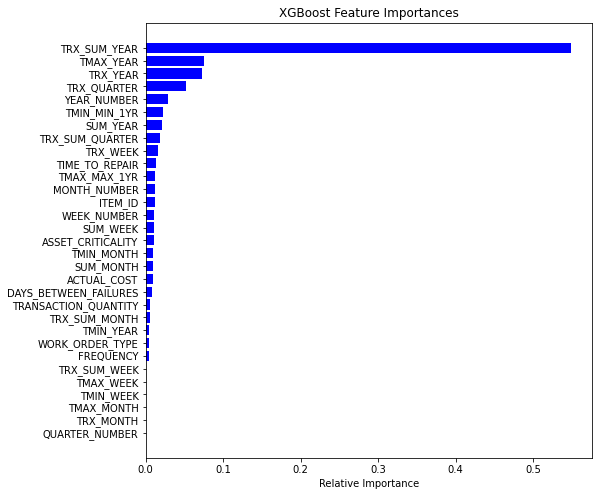

In [ ]:
features = list(df_avg.columns.values)
features = [f for f in features if f != 'RUL']
importances = xgb_avg.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8,8))
plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
# plt.savefig('/content/drive/My Drive/Hamiltonian/feature_importances.png', dpi=300, bbox_inches = 'tight')
plt.show()